In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv')

In [3]:
print("\nDataset shape:")
print(df.shape)


Dataset shape:
(7043, 21)


In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
print("\nColumn information:")
print(df.info())


Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  704

In [6]:
# coverting total charges to numeric
print("\n converting TotalCharges to numeric:")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df['TotalCharges'].describe())



 converting TotalCharges to numeric:
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64


In [7]:
print("\nChurn distribution:")
print(df['Churn'].value_counts(normalize=True))


Churn distribution:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [8]:
#categorical variables
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    print(f"\nUnique values in {column}:")
    print(df[column].value_counts())


Unique values in customerID:
customerID
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: count, Length: 7043, dtype: int64

Unique values in gender:
gender
Male      3555
Female    3488
Name: count, dtype: int64

Unique values in Partner:
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Unique values in Dependents:
Dependents
No     4933
Yes    2110
Name: count, dtype: int64

Unique values in PhoneService:
PhoneService
Yes    6361
No      682
Name: count, dtype: int64

Unique values in MultipleLines:
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

Unique values in InternetService:
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

Unique values in OnlineSecurity:
OnlineSecurity
No                     3498
Yes                  

1. Total charges has missing values.
2. Imbalanced dataset. approx. 74% No churn to 26% churn ratio.
3. categorical parameters with most of them having binary or tenary values.

In [9]:
# Handling missing values in 'TotalCharges'
imputer = SimpleImputer(strategy='mean')
df['TotalCharges'] = imputer.fit_transform(df[['TotalCharges']])

In [10]:
# Droping 'customerID' as it's not predictive
df = df.drop('customerID', axis=1)

In [11]:
# Encoding binary categorical variables
binary_vars = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
le = LabelEncoder()
for var in binary_vars:
    df[var] = le.fit_transform(df[var])

In [12]:
# One-hot encoding non-binary categorical variables
df = pd.get_dummies(df, columns=['MultipleLines', 'InternetService', 'OnlineSecurity',
                                 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'])

In [13]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,True,False,False,True,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,True,False,False,False,True,False,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,...,True,False,False,True,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,True,False,False,False,True,False,True,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,...,True,False,False,True,False,False,False,False,True,False


In [14]:
print("\nDataset shape after preprocessing:")
print(df.shape)
print("\nColumn information after preprocessing:")
print(df.info())


Dataset shape after preprocessing:
(7043, 41)

Column information after preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 41 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender                                   7043 non-null   int64  
 1   SeniorCitizen                            7043 non-null   int64  
 2   Partner                                  7043 non-null   int64  
 3   Dependents                               7043 non-null   int64  
 4   tenure                                   7043 non-null   int64  
 5   PhoneService                             7043 non-null   int64  
 6   PaperlessBilling                         7043 non-null   int64  
 7   MonthlyCharges                           7043 non-null   float64
 8   TotalCharges                             7043 non-null   float64
 9   Churn                         

In [15]:
non_numeric = df.select_dtypes(exclude=[np.number]).columns
print("\nRemaining non-numeric columns:")
print(non_numeric)


Remaining non-numeric columns:
Index(['MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')


In [16]:
# Converting boolean columns to int for correlation analysis
df_corr = df.copy()
bool_columns = df_corr.select_dtypes(include=['bool']).columns
df_corr[bool_columns] = df_corr[bool_columns].astype(int)

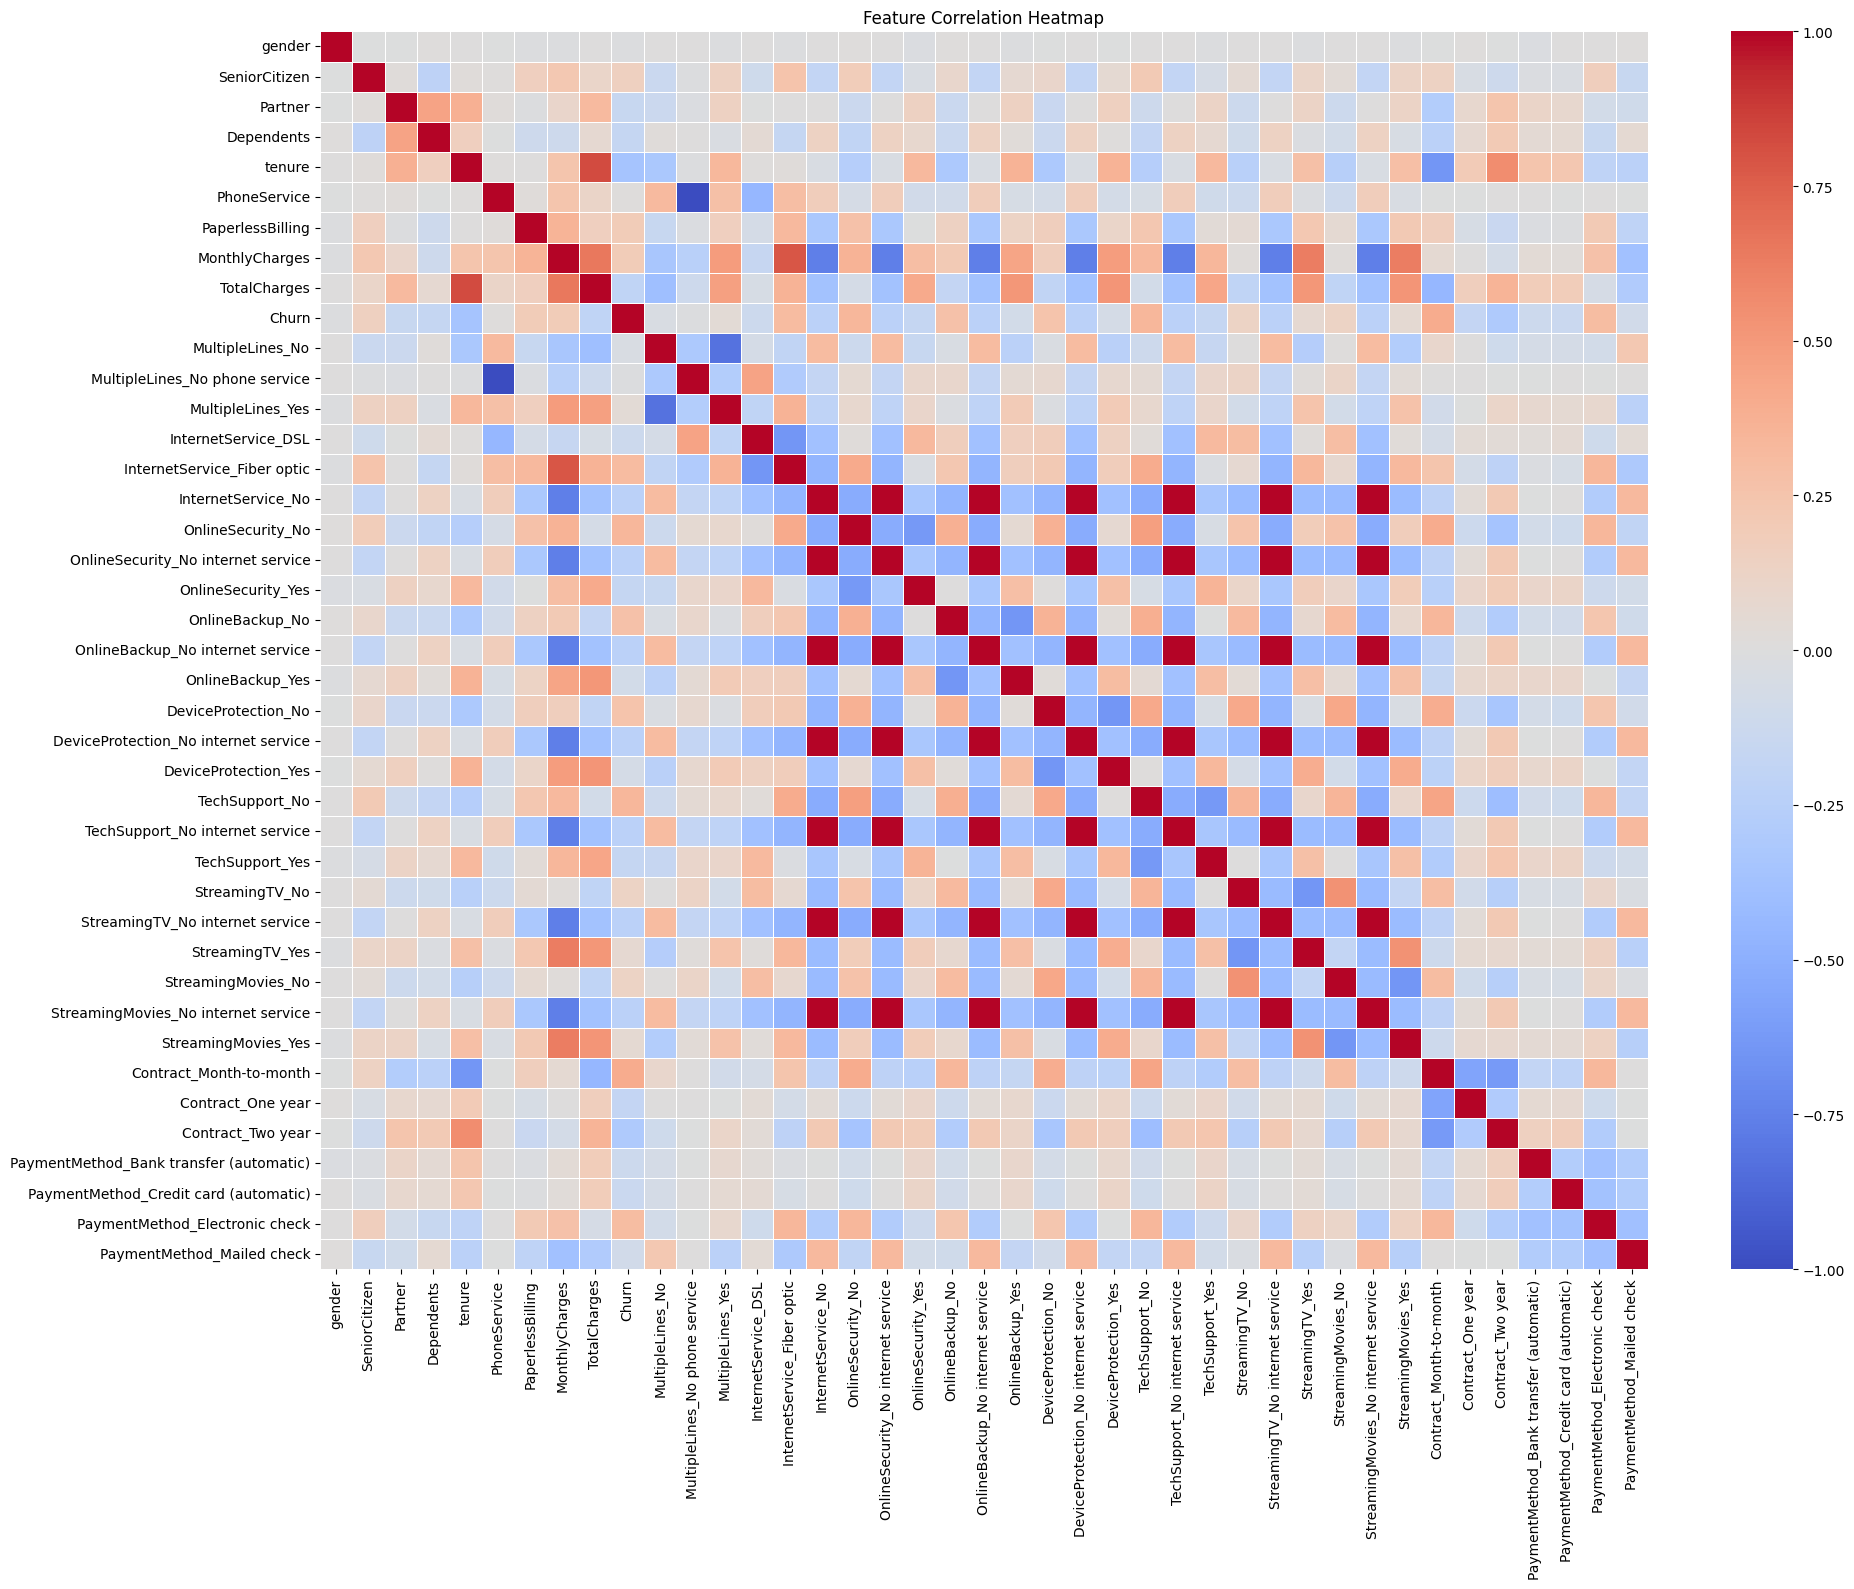

In [17]:
# correlation matrix
corr_matrix = df_corr.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

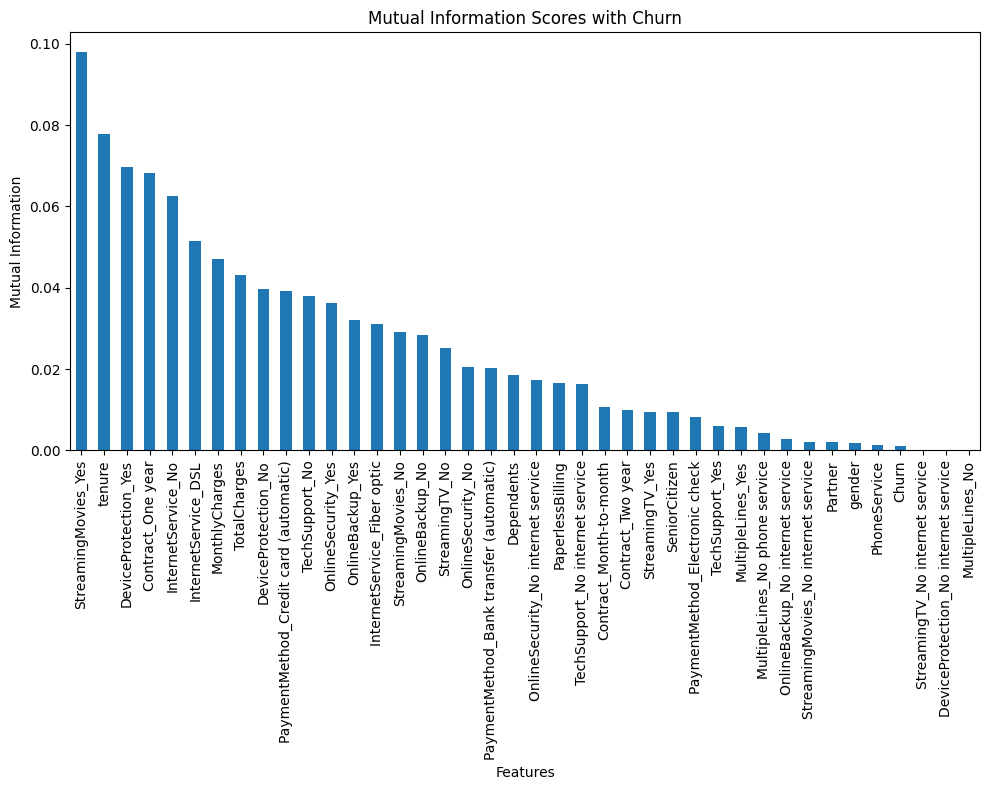

Top 10 features by mutual information score:
StreamingMovies_Yes                      0.097920
tenure                                   0.077912
DeviceProtection_Yes                     0.069710
Contract_One year                        0.068244
InternetService_No                       0.062658
InternetService_DSL                      0.051557
MonthlyCharges                           0.047147
TotalCharges                             0.043247
DeviceProtection_No                      0.039711
PaymentMethod_Credit card (automatic)    0.039125
dtype: float64


In [18]:
# mutual information scores
mi_scores = mutual_info_classif(df_corr.drop('Churn', axis=1), df_corr['Churn'])
mi_scores = pd.Series(mi_scores, index=df_corr.columns[:-1])
mi_scores = mi_scores.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
mi_scores.plot.bar()
plt.title('Mutual Information Scores with Churn')
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.show()

print("Top 10 features by mutual information score:")
print(mi_scores.head(10))

In [19]:
# Identifying highly correlated features
high_corr_features = np.where(np.abs(corr_matrix) > 0.8)
high_corr_features = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]

print("\nHighly correlated feature pairs:")
for feat1, feat2 in high_corr_features:
    print(f"{feat1} - {feat2}: {corr_matrix.loc[feat1, feat2]:.2f}")


Highly correlated feature pairs:
tenure - TotalCharges: 0.82
PhoneService - MultipleLines_No phone service: -1.00
MultipleLines_No - MultipleLines_Yes: -0.82
InternetService_No - OnlineSecurity_No internet service: 1.00
InternetService_No - OnlineBackup_No internet service: 1.00
InternetService_No - DeviceProtection_No internet service: 1.00
InternetService_No - TechSupport_No internet service: 1.00
InternetService_No - StreamingTV_No internet service: 1.00
InternetService_No - StreamingMovies_No internet service: 1.00
OnlineSecurity_No internet service - OnlineBackup_No internet service: 1.00
OnlineSecurity_No internet service - DeviceProtection_No internet service: 1.00
OnlineSecurity_No internet service - TechSupport_No internet service: 1.00
OnlineSecurity_No internet service - StreamingTV_No internet service: 1.00
OnlineSecurity_No internet service - StreamingMovies_No internet service: 1.00
OnlineBackup_No internet service - DeviceProtection_No internet service: 1.00
OnlineBacku

In [20]:
# Removing highly correlated features
features_to_drop = [
    'MultipleLines_No phone service',
    'OnlineSecurity_No internet service',
    'OnlineBackup_No internet service',
    'DeviceProtection_No internet service',
    'TechSupport_No internet service',
    'StreamingTV_No internet service',
    'StreamingMovies_No internet service'
]

df_selected = df.drop(columns=features_to_drop)

In [21]:
X = df_selected.drop('Churn', axis=1)
y = df_selected['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("Shape of training set:", X_train.shape)
print("Shape of testing set:", X_test.shape)
print("\nFeatures used in the model:")
print(X_train.columns.tolist())

Shape of training set: (5634, 33)
Shape of testing set: (1409, 33)

Features used in the model:
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'MultipleLines_No', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


In [22]:
#Dealing with Imbalance by giving lables weights

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print(class_weight_dict)


{0: 0.680763653939101, 1: 1.8830213903743316}


In [23]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Cross-Val ROC AUC': cv_scores.mean()
    }

In [24]:
# Logistic Regression
lr_model = LogisticRegression(class_weight=class_weight_dict, random_state=42)
lr_results = evaluate_model(lr_model, X_train, X_test, y_train, y_test)

# Random Forest
rf_model = RandomForestClassifier(class_weight=class_weight_dict, random_state=42)
rf_results = evaluate_model(rf_model, X_train, X_test, y_train, y_test)

# XGBoost
xgb_model = xgb.XGBClassifier(class_weight=class_weight_dict, random_state=42, enable_categorical=True)
xgb_results = evaluate_model(xgb_model, X_train, X_test, y_train, y_test)

# LightGBM
lgb_model = lgb.LGBMClassifier(class_weight=class_weight_dict, random_state=42, force_row_wise=True)
lgb_results = evaluate_model(lgb_model, X_train, X_test, y_train, y_test)


# Print results
print("Logistic Regression Results:")
for metric, value in lr_results.items():
    print(f"{metric}: {value:.4f}")

print("\nRandom Forest Results:")
for metric, value in rf_results.items():
    print(f"{metric}: {value:.4f}")


print("\nXGBoost Results:")
for metric, value in xgb_results.items():
    print(f"{metric}: {value:.4f}")

print("\nLightGBM Results:")
for metric, value in lgb_results.items():
    print(f"{metric}: {value:.4f}")



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:33:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:33:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:33:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:33:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:33:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1197, number of negative: 3310
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 4507, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500072 -> initscore=0.000288
[LightGBM] [Info] Start training from score 0.000288
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1197, number of negative: 3310
[LightGBM] [Info] Total Bins 644
[Lig

In [25]:
# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features (Random Forest):")
print(feature_importance.head(10))


Top 10 Important Features (Random Forest):
                           feature  importance
8                     TotalCharges    0.150711
4                           tenure    0.141414
7                   MonthlyCharges    0.139683
26         Contract_Month-to-month    0.087283
14               OnlineSecurity_No    0.038642
20                  TechSupport_No    0.032278
28               Contract_Two year    0.032182
12     InternetService_Fiber optic    0.027067
31  PaymentMethod_Electronic check    0.025978
0                           gender    0.024949


In [26]:
# Feature importance for XGBoost
xgb_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Important Features (XGBoost):")
print(xgb_feature_importance.head(15))


Top 15 Important Features (XGBoost):
                        feature  importance
26      Contract_Month-to-month    0.339573
12  InternetService_Fiber optic    0.256383
14            OnlineSecurity_No    0.029105
28            Contract_Two year    0.027814
5                  PhoneService    0.022664
11          InternetService_DSL    0.022429
20               TechSupport_No    0.022304
25          StreamingMovies_Yes    0.021033
27            Contract_One year    0.019272
4                        tenure    0.015684
16              OnlineBackup_No    0.014771
9              MultipleLines_No    0.014530
24           StreamingMovies_No    0.013560
1                 SeniorCitizen    0.011266
6              PaperlessBilling    0.011150


In [27]:
# Feature importance for LightGBM
lgb_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Important Features (LightGBM):")
print(lgb_feature_importance.head(15))


Top 15 Important Features (LightGBM):
                                    feature  importance
7                            MonthlyCharges         782
8                              TotalCharges         624
4                                    tenure         487
6                          PaperlessBilling          87
31           PaymentMethod_Electronic check          85
0                                    gender          83
2                                   Partner          64
1                             SeniorCitizen          59
9                          MultipleLines_No          59
14                        OnlineSecurity_No          50
29  PaymentMethod_Bank transfer (automatic)          45
20                           TechSupport_No          44
3                                Dependents          43
26                  Contract_Month-to-month          43
27                        Contract_One year          41


In [28]:
# Oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [29]:
# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_results = evaluate_model(lr_model, X_train_resampled, X_test, y_train_resampled, y_test)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_results = evaluate_model(rf_model, X_train_resampled, X_test, y_train_resampled, y_test)

# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, enable_categorical=True)
xgb_results = evaluate_model(xgb_model, X_train_resampled, X_test, y_train_resampled, y_test)

# LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42, force_row_wise=True)
lgb_results = evaluate_model(lgb_model, X_train_resampled, X_test, y_train_resampled, y_test)


# Print results
print("Logistic Regression Results:")
for metric, value in lr_results.items():
    print(f"{metric}: {value:.4f}")

print("\nRandom Forest Results:")
for metric, value in rf_results.items():
    print(f"{metric}: {value:.4f}")


print("\nXGBoost Results:")
for metric, value in xgb_results.items():
    print(f"{metric}: {value:.4f}")

print("\nLightGBM Results:")
for metric, value in lgb_results.items():
    print(f"{metric}: {value:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4138, number of negative: 4138
[LightGBM] [Info] Total Bins 825
[LightGBM] [Info] Number of data points in the train set: 8276, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3310, number of negative: 3310
[LightGBM] [Info] Total Bins 825
[LightGBM] [Info] Number of data points in the train set: 6620, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3311, number of negative: 3310
[LightGBM] [Info] Total Bins 825
[LightGBM] [Info] Number of data points in the train set: 6621, number of used features: 33
[LightGBM] [Info] [b

In [30]:
# Feature Engineering
def engineer_features(df):
    df['TotalCharges_tenure'] = df['TotalCharges'] * df['tenure']
    df['MonthlyCharges_tenure'] = df['MonthlyCharges'] * df['tenure']

    # Bin tenure (adjust bins to cover all possible values)
    df['tenure_bin'] = pd.cut(df['tenure'],
                              bins=[-np.inf, 12, 24, 36, 48, 60, np.inf],
                              labels=[1, 2, 3, 4, 5, 6])

    return df


X_engineered = engineer_features(X)

In [31]:
print("Columns with NaN values:")
print(X_engineered.isna().sum()[X_engineered.isna().sum() > 0])

Columns with NaN values:
Series([], dtype: int64)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_engineered, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalCharges_tenure', 'MonthlyCharges_tenure']
X_train_resampled[numerical_features] = scaler.fit_transform(X_train_resampled[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [42]:
X_train_resampled['tenure_bin'] = pd.cut(X_train_resampled['tenure'],
                              bins=[-np.inf, 12, 24, 36, 48, 60, np.inf],
                              labels=[1, 2, 3, 4, 5, 6])

In [43]:
X_train_resampled.isnull().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
PaperlessBilling,0
MonthlyCharges,0
TotalCharges,0
MultipleLines_No,0


In [44]:
# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_results = evaluate_model(lr_model, X_train_resampled, X_test, y_train_resampled, y_test)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_results = evaluate_model(rf_model, X_train_resampled, X_test, y_train_resampled, y_test)

# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, enable_categorical=True)
xgb_results = evaluate_model(xgb_model, X_train_resampled, X_test, y_train_resampled, y_test)

# LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42, force_row_wise=True)
lgb_results = evaluate_model(lgb_model, X_train_resampled, X_test, y_train_resampled, y_test)


# Print results
print("Logistic Regression Results:")
for metric, value in lr_results.items():
    print(f"{metric}: {value:.4f}")

print("\nRandom Forest Results:")
for metric, value in rf_results.items():
    print(f"{metric}: {value:.4f}")


print("\nXGBoost Results:")
for metric, value in xgb_results.items():
    print(f"{metric}: {value:.4f}")

print("\nLightGBM Results:")
for metric, value in lgb_results.items():
    print(f"{metric}: {value:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4138, number of negative: 4138
[LightGBM] [Info] Total Bins 1154
[LightGBM] [Info] Number of data points in the train set: 8276, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3310, number of negative: 3310
[LightGBM] [Info] Total Bins 1154
[LightGBM] [Info] Number of data points in the train set: 6620, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3311, number of negative: 3310
[LightGBM] [Info] Total Bins 1154
[LightGBM] [Info] Number of data points in the train set: 6621, number of used features: 35
[LightGBM] [Info]

Logistic Regression model performs best.

In [46]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

lr = LogisticRegression(random_state=42)

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_lr = grid_search.best_estimator_
lr_results = evaluate_model(best_lr, X_train_resampled, X_test, y_train_resampled, y_test)

print("\nTuned Logistic Regression Results:")
for metric, value in lr_results.items():
    print(f"{metric}: {value:.4f}")

Best parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.9327430567813527

Tuned Logistic Regression Results:
Accuracy: 0.7892
Precision: 0.6484
Recall: 0.4450
F1 Score: 0.5278
ROC AUC: 0.7927
Cross-Val ROC AUC: 0.9327


In [47]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'num_leaves': [31, 63, 127],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

lgb_model = lgb.LGBMClassifier(random_state=42, force_row_wise = True)

grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use the best model for predictions
best_lgb_model = grid_search.best_estimator_
lgb_results = evaluate_model(lgb_model, X_train_resampled, X_test, y_train_resampled, y_test)

print("\nLightGBM Results:")
for metric, value in lgb_results.items():
    print(f"{metric}: {value:.4f}")

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4138, number of negative: 4138
[LightGBM] [Info] Total Bins 1154
[LightGBM] [Info] Number of data points in the train set: 8276, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

Top 15 Important Features (LightGBM):
                                    feature  importance
7                            MonthlyCharges         994
8                              TotalCharges         699
33                      TotalCharges_tenure         608
4                                    tenure         527
34                    MonthlyCharges_tenure         497
31           PaymentMethod_Electronic check         171
0                                    gender         152
16                          OnlineBackup_No         136
30    PaymentMethod_Credit card (automatic)         127
29  PaymentMethod_Bank transfer (automatic)         121
20                           TechSupport_No         119
14                        OnlineSecurity_No         114
27                        Contract_One year         110
2                                   Partner         104
6                          PaperlessBilling         104


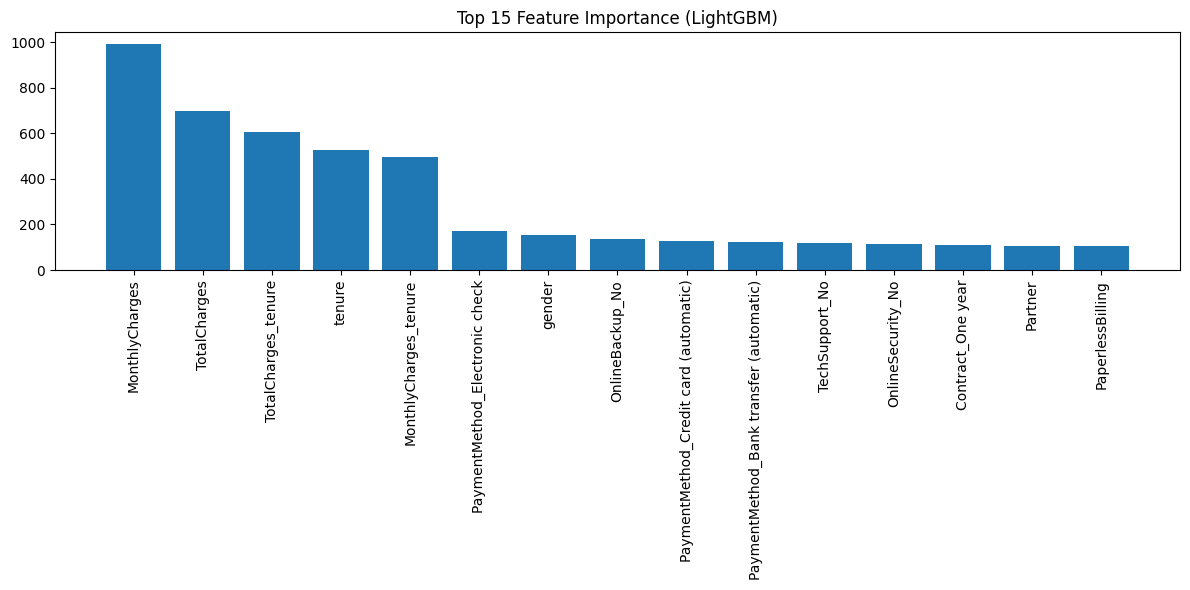

In [50]:
feature_importance_lgb = pd.DataFrame({
    'feature': X_train_resampled.columns,
    'importance': best_lgb_model.feature_importances_
})
feature_importance_lgb = feature_importance_lgb.sort_values('importance', ascending=False)

print("Top 15 Important Features (LightGBM):")
print(feature_importance_lgb.head(15))

plt.figure(figsize=(12, 6))
plt.bar(feature_importance_lgb['feature'][:15], feature_importance_lgb['importance'][:15])
plt.xticks(rotation=90)
plt.title('Top 15 Feature Importance (LightGBM)')
plt.tight_layout()
plt.show()

## Insights

**Financial Factors:** MonthlyCharges, TotalCharges, and their interactions with tenure are the most important predictors of churn. This suggests that pricing and billing play a crucial role in customer retention.

**Tenure:** Customer tenure is a significant factor, both on its own and in interaction with charges. This indicates that the length of the customer relationship influences churn risk.

**Payment Method:** Electronic check payments are associated with higher churn risk compared to other payment methods.

**Service Features:** The absence of certain services (OnlineBackup, TechSupport, OnlineSecurity) is important for churn. This suggests that customers without these services are more likely to leave.

**Contract Type:** One-year contracts have a notable impact on churn, likely reducing churn risk compared to month-to-month contracts.

**Demographics**: Gender and partner status have some influence on churn, though less than financial and service-related factors.

## Recommendations

**Pricing Strategy Review:**
- Analyze the relationship between monthly charges and churn rates.
- Consider offering loyalty discounts or rewards for long-term customers to improve retention.
- Develop targeted pricing strategies for high-risk segments.

**Payment Method Optimization:**
- Encourage customers to switch from electronic check payments to other methods.
- Investigate why electronic check users are more likely to churn and address any related issues.

**Service Bundle Promotion:**
- Create attractive bundles that include OnlineBackup, TechSupport, and OnlineSecurity.
- Educate customers on the benefits of these services to encourage adoption.

**Contract Length Incentives:**
- Promote longer contract terms by offering incentives for one-year or two-year commitments.
- Develop strategies to convert month-to-month customers to longer-term contracts.

**Early Intervention Program:**
- Implement a system to identify customers at high risk of churn based on these key features.
- Develop proactive outreach programs to address concerns and offer solutions before customers decide to leave.

By focusing on these areas, the company can develop a more effective retention strategy, potentially reducing churn rates and improving overall customer lifetime value.